Resnet-50 From Scratch

In [1]:
import numpy as np
import pandas as pd
import os 
inputFolder = '/content/drive/MyDrive/FER2013KaggleOri/fer2013/Resnet50Scracth' 
for root, directories, filenames in os.walk(inputFolder): 
    for filename in filenames: print(os.path.join(root,filename))

/content/drive/MyDrive/FER2013KaggleOri/fer2013/Resnet50Scracth/Scracthfer2013.csv
/content/drive/MyDrive/FER2013KaggleOri/fer2013/Resnet50Scracth/scratchcheckpoint/Best_Model_resnet50Scracth_tipe1.h5
/content/drive/MyDrive/FER2013KaggleOri/fer2013/Resnet50Scracth/scratchcheckpoint/Best_Model_resnet50Scracth_tipe4.h5


In [2]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model


from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:400: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
#Create a directory to save our generated models.

os.mkdir("./modelscracth")

In [3]:
#Define the identity block helper function.
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [5]:
def ResNet50(input_shape = (48,48,1), classes = 7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    #X = ZeroPadding2D((1, 1))(X_input)
    X = X_input
    # Stage 1

    X = Conv2D(8, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    # removed maxpool
    #X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL . 
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(512, activation = 'relu', name='fc1024' , kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [6]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
 
dataset_path = '/content/drive/MyDrive/FER2013KaggleOri/fer2013/Resnet50Scracth/Scracthfer2013.csv'
image_size=(48,48)
batch_size = 32

def load_fer2013():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)
#Data Augumentation
data_generator = ImageDataGenerator(
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [7]:
#hyperparameter and callback
batch_size = 64
num_epochs = 50
input_shape = (48, 48, 1)
num_classes = 7


In [8]:
#Compile the model.


from keras.optimizers import Adam, SGD
model = ResNet50(input_shape = (48, 48, 1), classes = 7)
optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#kita mau save model callbacks
import os
try:
  os.mkdir('scratchcheckpoint')
except:
  pass

In [9]:
file_name = 'Best_Model_resnet50Scracth_tipe5.h5'

checkpoint_path = os.path.join('checkpoint',file_name)

In [10]:
call_back = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_freq='epoch',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max')

In [11]:
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 46, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 46, 46, 8)    32          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [12]:
history = model.fit(data_generator.flow(xtrain, ytrain,),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1,callbacks=call_back,
                        validation_data= (xtest,ytest))

Epoch 1/50
448/448 [==============================] - 114s 130ms/step - loss: 2.2916 - accuracy: 0.2095 - val_loss: 1.8810 - val_accuracy: 0.2566

Epoch 00001: val_accuracy improved from -inf to 0.25662, saving model to checkpoint/Best_Model_resnet50Scracth_tipe5.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
448/448 [==============================] - 51s 115ms/step - loss: 1.7767 - accuracy: 0.2644 - val_loss: 1.7588 - val_accuracy: 0.2834

Epoch 00002: val_accuracy improved from 0.25662 to 0.28337, saving model to checkpoint/Best_Model_resnet50Scracth_tipe5.h5
Epoch 3/50
448/448 [==============================] - 52s 115ms/step - loss: 1.7348 - accuracy: 0.2958 - val_loss: 1.7540 - val_accuracy: 0.2962

Epoch 00003: val_accuracy improved from 0.28337 to 0.29618, saving model to checkpoint/Best_Model_resnet50Scracth_tipe5.h5
Epoch 4/50
448/448 [==============================] - 56s 126ms/step - loss: 1.6668 - accuracy: 0.3421 - val_loss: 1.6710 - val_accuracy: 0.3392

Epoch 00004: val_accuracy improved from 0.29618 to 0.33923, saving model to checkpoint/Best_Model_resnet50Scracth_tipe5.h5
Epoch 5/50
448/448 [==============================] - 52s 115ms/step - loss: 1.5909 - accuracy: 0.3707 - val_loss: 1.7288 - val_accuracy: 0.3796

Epoch 00005: val_accuracy improved from 0.33923

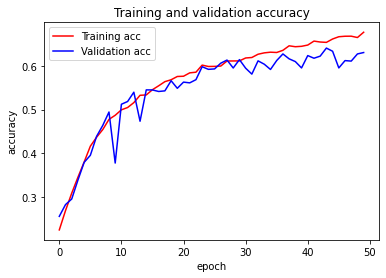

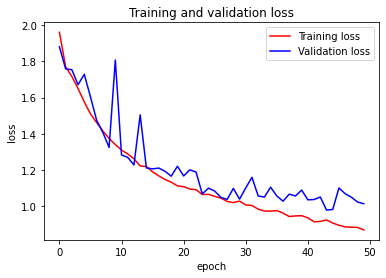

In [13]:
import matplotlib.pyplot as plt 

#gffhgffkjkjds
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
num_epochs = range(len(accuracy))
plt.plot(num_epochs, accuracy, 'r', label='Training acc')
plt.plot(num_epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(num_epochs, loss, 'r', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()